# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [42]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt
import LinearModelsPS2_post as lm
import scipy
from tabulate import tabulate
from scipy.stats import chi2

In [43]:
# Read data
dat = pd.read_csv('firms.csv')

dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1973.500000,-7.125472e-09,-1.252834e-08,4.695767e-09
std,127.317437,3.452379,1.310973e+00,1.180122e+00,1.232499e+00
min,1.000000,1968.000000,-3.864950e+00,-3.382780e+00,-3.551540e+00
25%,111.000000,1970.750000,-9.083267e-01,-7.855270e-01,-9.279720e-01
50%,221.000000,1973.500000,-1.180615e-01,-1.137295e-01,-1.029710e-01
75%,331.000000,1976.250000,9.063340e-01,7.930060e-01,8.562296e-01
max,441.000000,1979.000000,4.103687e+00,3.371332e+00,3.913391e+00


In [44]:
# Check if the panel is balanced
N = dat.firmid.nunique()
T = dat.year.nunique()
assert dat.shape[0] == N * T, f'Error: data is not a balanced panel'

# Convert data to panel structure
dat = dat.set_index(['firmid', 'year'])

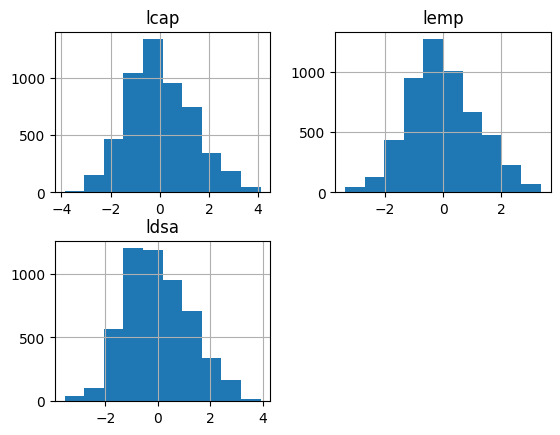

In [45]:
# Visualiseringer
dat[['lcap', 'lemp', 'ldsa']].hist()
plt.show()

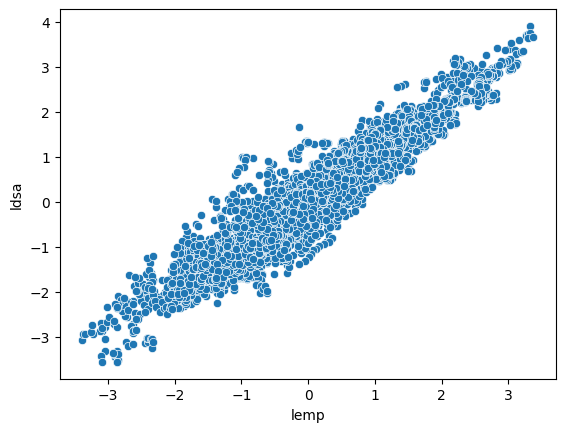

In [46]:
sns.scatterplot(x='lemp', y='ldsa', data=dat)
plt.show()

**$\textcolor{red}{HJÆLPE}$ $\textcolor{red}{KODER}$**

In [47]:
# Indlæs data
dat = pd.read_csv('firms.csv')

dat = dat[dat["year"] < 1971]
print(dat)

      firmid  year      lcap      lemp      ldsa
0          1  1968  0.998602 -0.242185  0.349053
1          1  1969  0.925214 -0.241278  0.312492
2          1  1970  0.879616 -0.265134  0.347566
12         2  1968 -0.069588 -0.323021 -0.945831
13         2  1969 -0.056724 -0.358177 -1.143830
...      ...   ...       ...       ...       ...
5269     440  1969 -0.228757  0.031242 -0.246864
5270     440  1970 -0.038354  0.062158 -0.345710
5280     441  1968 -1.618390 -1.944210 -2.032340
5281     441  1969 -1.635030 -1.856580 -2.011210
5282     441  1970 -1.454890 -1.538940 -1.371550

[1323 rows x 5 columns]


In [48]:
dat.sample(5) 

,firmid,year,lcap,lemp,ldsa
5174,432,1970,0.755775,0.448408,0.101072
1609,135,1969,-1.523270,-1.463500,-1.854680
4333,362,1969,-0.998183,-1.164580,-0.878541
1598,134,1970,-0.264126,-0.396820,-0.577028
3456,289,1968,-1.313910,-1.124520,-1.464560


In [49]:
dat.year.unique()

array([1968, 1969, 1970])

# Descriptives

In [50]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,1323.000000,1323.000000,1.323000e+03,1.323000e+03,1.323000e+03
mean,221.000000,1969.000000,-3.432577e-08,5.291005e-09,3.253968e-08
std,127.353547,0.816805,1.367661e+00,1.212370e+00,1.238870e+00
min,1.000000,1968.000000,-3.864950e+00,-3.108660e+00,-3.433130e+00
25%,111.000000,1968.000000,-9.629080e-01,-8.435585e-01,-9.082370e-01
50%,221.000000,1969.000000,-1.016350e-01,-1.141760e-01,-1.142770e-01
75%,331.000000,1970.000000,9.708763e-01,8.067791e-01,8.648864e-01
max,441.000000,1970.000000,3.993508e+00,3.187258e+00,3.418170e+00


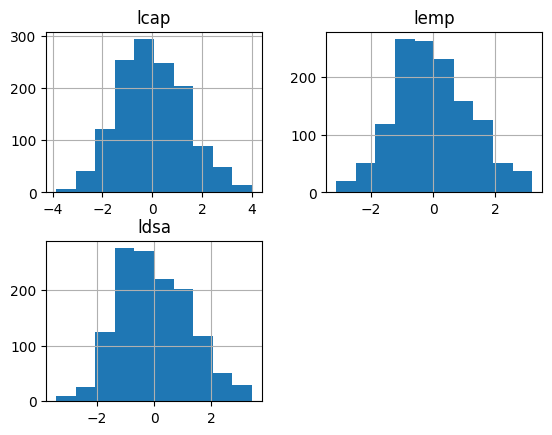

In [51]:
dat[['lcap','lemp','ldsa']].hist();

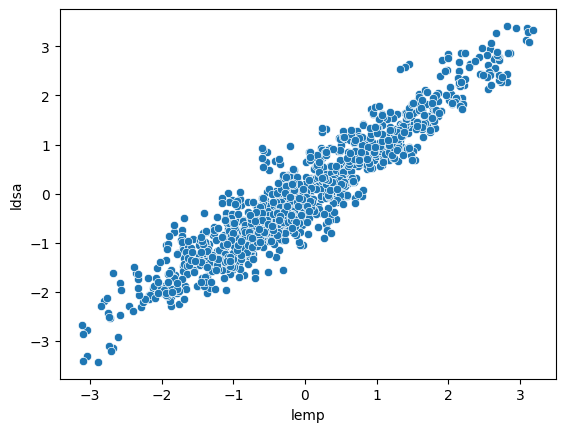

In [52]:
sns.scatterplot(x='lemp', y='ldsa', data=dat); 

# Converting data to numpy format 

In [53]:
dat.ldsa.values.shape

(1323,)

In [54]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=3


Extract data from `pandas` to `numpy` arrays. 

In [55]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])

xlbl = ["constant", "lcap", "lemp"]
ylbl = ["ldsa"]

**Pooled OLS**

In [56]:
help(lm.estimate)


Help on function estimate in module LinearModelsPS2_post:

estimate(y: numpy.ndarray, x: numpy.ndarray, transform='', N=None, T=None) -> list



In [58]:
#Pooled OLS
estimation_POLS = lm.estimate(y, X, robust_se=True, T=T)
lm.print_table((ylbl, xlbl), estimation_POLS, title="POLS")

#Wald test for H_0: B_L+B_K=1 -> B_L+B_K-1=0

C_OLS = np.array([[0,1,1]])
cov_m_OLS = estimation_POLS["cov"]
betas_OLS = estimation_POLS["b_hat"]
wald_OLS = (C_OLS @ betas_OLS).T @ np.linalg.inv((C_OLS @ cov_m_OLS @ C_OLS.T)) @ (C_OLS @ betas_OLS)

p_value_OLS = 1 - scipy.stats.chi2.cdf(wald_OLS, 1)
print("Wald test statistic: ", wald_OLS[0][0])
print("p-value: ", p_value_OLS[0][0])

TypeError: estimate() got an unexpected keyword argument 'robust_se'